In [1]:
import math
from scipy.spatial.transform import Rotation as R

def fibonacci_sphere(samples=1):
    points = []
    phi = math.pi * (3. - math.sqrt(5.))  # golden angle in radians

    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = math.sqrt(1 - y * y)  # radius at y

        theta = phi * i  # golden angle increment

        x = math.cos(theta) * radius
        z = math.sin(theta) * radius

        points.append((x, y, z))
    return points

def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

In [10]:
import k3d
import numpy as np

def get_mat(nr_points):
    points = fibonacci_sphere(nr_points)
    mat = []
    for i in range(0, nr_points):
        mat.append(rotation_matrix_from_vectors(np.array([1,0,0]),np.array(points[i])))
    return np.array(mat)


nr_points = 30
points = fibonacci_sphere(nr_points)
mat = []
for i in range(0, nr_points):
    mat.append(rotation_matrix_from_vectors(np.array([1,0,0]),np.array(points[i])))
mat = np.array(mat)

# validateing matrix by plotting the camera viewpoints
unit_point = np.zeros( (nr_points,3) )
unit_point[:,0] = 1

for i in range(0,nr_points):
    unit_point[i,:] =  unit_point[i,:].dot( mat[i,:,:] )
    

plot = k3d.plot(name='points')

points = unit_point.tolist()

point_size = 0.05
x_rgb = (0,0,255)
x_col = []
for i in range (0, len(points )):
    rgb_int = int('%02x%02x%02x' % x_rgb, 16)
    x_col.append( rgb_int ) 

plt_points = k3d.points(points, np.array(x_col).astype(np.uint32), point_size=point_size)
plot += plt_points

plt_points.shader='3d'
plot.display()

Output()

In [8]:
import os
os.environ['PYOPENGL_PLATFORM'] = 'osmesa'
import pyglet
import trimesh
import numpy as np
import trimesh
import pyrender
from math import pi
from PIL import Image
import copy
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import cv2
import scipy.io as scio
import pickle as pkl
import time
import imageio
#same as ycb first go and synthetic data of ycb
cx = 312.9869
cy = 241.3109
fx = 1066.778
fy = 1067.487

obj = '005_tomato_soup_can'#'005_tomato_soup_can'
obj_idx_tomoto_soup = 4

model = '/media/scratch1/jonfrey/datasets/YCB_Video_Dataset/models'
base = '/media/scratch1/jonfrey/datasets/YCB_Video_Dataset/data/0003'
desig = '000010'
store = '/media/scratch1/jonfrey/datasets/YCB_Video_Dataset/viewpoints_renderings'

img = Image.open('{0}/{1}-color.png'.format(base, desig))
depth = Image.open('{0}/{1}-depth.png'.format(base, desig))
meta = scio.loadmat('{0}/{1}-meta.mat'.format(base, desig))

obj_tmp = meta['cls_indexes'].flatten().astype(np.int32)
obj_idx_in_list = int(np.argwhere(obj_tmp == obj_idx_tomoto_soup))
target_r = np.array(meta['poses'][:, :, obj_idx_in_list][:, 0:3])
target_t = np.array(
    [meta['poses'][:, :, obj_idx_in_list][:, 3:4].flatten()])[0,:]


def render_obj(obj, model, store, idx, obj_dis, r_mat,fx, fy, cx, cy,):
    ### params
    w = 640
    h = 480

    path = os.path.join(store, obj)
    if not os.path.exists(path):
        os.mkdir(path)
    obj_mesh = trimesh.load(f'{model}/{obj}/textured.obj')
    mesh = pyrender.Mesh.from_trimesh(obj_mesh, smooth=True, wireframe=False)
    scene = pyrender.Scene(bg_color=(0, 0, 0, 255))
    
    pose_obj = np.eye(4)
    pose_obj[:3, 3] = [0, 0, obj_dis]
    pose_obj[:3, :3] = r_mat

    scene.add(mesh, pose=copy.copy(pose_obj))
    ren = pyrender.OffscreenRenderer(w, h, point_size=1)


    
    camera = pyrender.IntrinsicsCamera(
        fx, fy, cx, cy, znear=0.1, zfar=2, name=None)
    camera_pose = np.array([
        [1, 0, 0, 0],
        [0, 1, 0.0, 0],
        [0.0, 0, 1, 0],
        [0.0, 0.0, 0.0, 1.0],
    ])
    camera_pose[:3,:3] = R.from_euler('xyz',[0,180,180], degrees=True).as_matrix()
    scene.add(camera, pose=camera_pose)
    light = pyrender.SpotLight(color=np.ones(3), intensity=25.0,
                               innerConeAngle=np.pi * 0.1)
    scene.add(light, pose=camera_pose)
    color, depth = ren.render(scene)
    color = color[:,:,[2,1,0]] #change to rgb 
    cv2.imwrite(f'{path}/{idx}.png',color)
    print(depth)
    
    
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    plt.imshow(depth)
    plt.axis("off")
    fig.add_subplot(1, 2, 2)
    color = color[:,:,[2,1,0]]
    plt.imshow(color)
    plt.axis("off")
    plt.show()
    
    return color,depth

class RenderSingleObj():
    def __init__(self,obj, model, store,fx, fy, cx, cy, w, h):

        self.path = os.path.join(store, obj)
        if not os.path.exists(self.path):
            os.mkdir(self.path)
            
            
        obj_mesh = trimesh.load(f'{model}/{obj}/textured.obj')
        self.mesh = pyrender.Mesh.from_trimesh(obj_mesh, smooth=True, wireframe=False)
        
        self.scene = pyrender.Scene(bg_color=(0, 0, 0, 255))
        
        self.ren = pyrender.OffscreenRenderer(w, h, point_size=1)



        camera = pyrender.IntrinsicsCamera(
            fx, fy, cx, cy, znear=0.1, zfar=2, name=None)
        camera_pose = np.array([
            [1, 0, 0, 0],
            [0, 1, 0.0, 0],
            [0.0, 0, 1, 0],
            [0.0, 0.0, 0.0, 1.0],
        ])
        camera_pose[:3,:3] = R.from_euler('xyz',[0,180,180], degrees=True).as_matrix()
        self.scene.add(camera, pose=camera_pose)
        light = pyrender.SpotLight(color=np.ones(3), intensity=25.0,
                                   innerConeAngle=np.pi * 0.1)
        self.scene.add(light, pose=camera_pose)
        
        pose_obj = np.eye(4)
        self.obj_node = self.scene.add(self.mesh, pose=pose_obj)
        
    def render(self, idx, obj_dis , r_mat, plot):
        
        pose_obj = np.eye(4)
        pose_obj[:3, 3] = [0, 0, obj_dis]
        pose_obj[:3, :3] = r_mat
        
        self.scene.set_pose(self.obj_node, pose=pose_obj)
        
        color, depth = self.ren.render(self.scene)
        color = color[:,:,[2,1,0]] #change to rgb 
        cv2.imwrite(f'{self.path}/{idx}-color.png',color)
        
        depth_store = np.array(depth * 10000, dtype=np.uint16)
        imageio.imwrite(f'{self.path}/{idx}-depth.png', depth_store)
        
        if np.amax(depth_store[0,:]) != 0 or \
            np.amax(depth_store[-1,:]) != 0 or \
            np.amax(depth_store[:,0]) != 0 or \
            np.amax(depth_store[:,-1]) != 0:
            print("ERRRORORRR RUN obj again")
            return None, None
            
                
        if plot:
            fig = plt.figure()
            fig.add_subplot(1, 2, 1)
            plt.imshow(depth)
            plt.axis("off")
            fig.add_subplot(1, 2, 2)
            color = color[:,:,[2,1,0]]
            plt.imshow(color)
            plt.axis("off")
            plt.show()
        
        return color,depth


print(generic._backend._name_to_idx)
obj_names = list(generic._backend._name_to_idx.keys())
obj_scale = [0.4]* len(obj_names)
print(obj_scale)

for j, obj in enumerate(obj_names):
    renSingObj = RenderSingleObj(obj, model, store,fx, fy, cx, cy, w=640, h=480 )
    broken = False
    print("start", obj)
    while 1:
        if broken:
            obj_scale[j] += 0.1  
            print("incresed", obj, " to ",obj_scale[j] )
        
        # try to render the object with the set distance
        broken = False
        
        for i in range(nr_points): #nr_points
            start = time.time()

            res, res2 = renSingObj.render(idx=i, obj_dis=obj_scale[j] , r_mat= mat[i] , plot= False)
            delta = time.time() - start
            #print(f'Progress: {i}/{nr_points}, Estimated time: {(nr_points-i)*delta}s, fps: {delta} s')
            if res is None:
                print("broken")
                broken = True
                break
        if not broken:
            print("Obs was successfull ended up useing", obj_scale[j])
            break

obj_names_repeat= ['002_master_chef_can','019_pitcher_base','021_bleach_cleanser']
# these 3 object fit to tight. Therfore increase the bb. 
# they work with 30 points but dont wih 500 (this is expected)
obj_scale[10] = 0.8
obj_scale[11] = 0.7
obj_scale[0] = 0.5

{'002_master_chef_can': 1, '003_cracker_box': 2, '004_sugar_box': 3, '005_tomato_soup_can': 4, '006_mustard_bottle': 5, '007_tuna_fish_can': 6, '008_pudding_box': 7, '009_gelatin_box': 8, '010_potted_meat_can': 9, '011_banana': 10, '019_pitcher_base': 11, '021_bleach_cleanser': 12, '024_bowl': 13, '025_mug': 14, '035_power_drill': 15, '036_wood_block': 16, '037_scissors': 17, '040_large_marker': 18, '051_large_clamp': 19, '052_extra_large_clamp': 20, '061_foam_brick': 21}
[0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4]
start 002_master_chef_can
Obs was successfull ended up useing 0.4
start 003_cracker_box
ERRRORORRR RUN obj again
broken
incresed 003_cracker_box  to  0.5
ERRRORORRR RUN obj again
broken
incresed 003_cracker_box  to  0.6
ERRRORORRR RUN obj again
broken
incresed 003_cracker_box  to  0.7
Obs was successfull ended up useing 0.7
start 004_sugar_box
ERRRORORRR RUN obj again
broken
incresed 004_sugar_box  to  0.5
Obs was

NameError: name 'obj_dis' is not defined

In [23]:
# input is obj_scale and obj_names

nr_points = 500
# comute camera matrix for nr_points
mat = get_mat(nr_points)

# best way to store cam cal use matrix defined here
# https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html
cam_mat = np.zeros( (nr_points,3,3) )
cam_mat[:,2,2] = 1
cam_mat[:,0,0] = fx
cam_mat[:,1,1] = fy
cam_mat[:,0,2] = cx
cam_mat[:,1,2] = cy


# render all objects with 500 viewpoints each

for j, obj in enumerate(obj_names):
    print("Start", obj)
    
    # creat renderer
    renSingObj = RenderSingleObj(obj, model, store,fx, fy, cx, cy, w=640, h=480 )
    
    # store cam pose for each frame
    homo = np.repeat(np.eye(4).reshape((1,4,4)),nr_points, axis=0)
    homo[:,:3,:3] = np.array(mat)
    homo[:,:3,3] = [0,0,obj_scale[j]]
    
    # dump pose and cam_calibration matrix
    pkl.dump( homo, open( f'{store}/{obj}/pose.pkl', "wb" ) )
    pkl.dump( cam_mat, open( f'{store}/{obj}/cam.pkl', "wb" ) )
    
    
    # render frames
    for i in range(nr_points): #nr_points
        start = time.time()
        res, res2 = renSingObj.render(idx=i, obj_dis=obj_scale[j] , r_mat= mat[i] , plot= False)
        delta = time.time() - start
        if i % 50 == 1:
            print(f'Progress: {i}/{nr_points}, Estimated time: {(nr_points-i)*delta}s, fps: {delta} s')
        if res is None:
            print("ERRRRRRRRRRROOOOOOOOOOORRRRR")
            break


Start 002_master_chef_can
Progress: 1/500, Estimated time: 149.08846592903137s, fps: 0.29877448081970215 s
Progress: 51/500, Estimated time: 140.15599298477173s, fps: 0.3121514320373535 s
Progress: 101/500, Estimated time: 122.76265954971313s, fps: 0.307675838470459 s
Progress: 151/500, Estimated time: 113.53734755516052s, fps: 0.32532191276550293 s
Progress: 201/500, Estimated time: 106.36784934997559s, fps: 0.3557453155517578 s
Progress: 251/500, Estimated time: 77.94643020629883s, fps: 0.3130378723144531 s
Progress: 301/500, Estimated time: 64.80429792404175s, fps: 0.3256497383117676 s
Progress: 351/500, Estimated time: 49.021106004714966s, fps: 0.32900071144104004 s
Progress: 401/500, Estimated time: 35.43777894973755s, fps: 0.3579573631286621 s
Progress: 451/500, Estimated time: 16.58013415336609s, fps: 0.33837008476257324 s
Start 019_pitcher_base
Progress: 1/500, Estimated time: 130.15127754211426s, fps: 0.26082420349121094 s
Progress: 51/500, Estimated time: 115.63395571708679s,

In [6]:
# load test of hyper_params
test = pkl.load( open( f'{store}/{obj}/pose.pkl', "rb" ) )
print(f'{store}/{obj}/pose.pkl')

/media/scratch1/jonfrey/datasets/YCB_Video_Dataset/viewpoints_renderings/005_tomato_soup_can/pose.pkl


<class 'PIL.PngImagePlugin.PngImageFile'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
8150 0 3728 3326
10000
0.4355
0.0


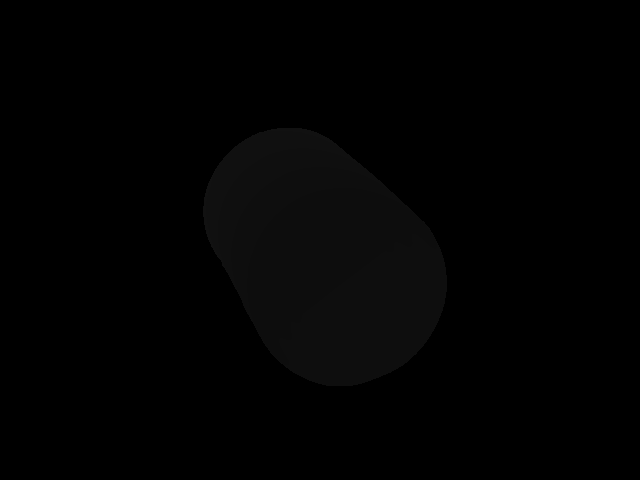

In [4]:
# only used to verify the generated depth map

from PIL import Image
base = '/media/scratch1/jonfrey/datasets/YCB_Video_Dataset/data/0003'
desig = '000010'
obj_idx_tomoto_soup = 4

img = Image.open('{0}/{1}-color.png'.format(base, desig))
depth = Image.open('{0}/{1}-depth.png'.format(base, desig))
meta = scio.loadmat('{0}/{1}-meta.mat'.format(base, desig))



depth_ren = Image.open('/media/scratch1/jonfrey/datasets/YCB_Video_Dataset/viewpoints_renderings/005_tomato_soup_can/1-depth.png')

#np.amax(render_depth*10000)
#np.amin(depth)
np.amin(depth)

depth
print(type(depth))
d_arr = np.array(depth)
d_r_arr = np.array(depth_ren)
print(d_r_arr[100:200,100:200] )

depth
print( np.amax(d_arr[200:280, 250:350]), np.amin(d_arr[200:280, 250:350]) ,  np.amax( d_r_arr[200:280, 250:350] ), np.amin(d_r_arr[200:280, 250:350])  )
depth_ren


depth_masked = d_r_arr.flatten()[:, np.newaxis].astype(np.float32)
xmap = np.array([[j for i in range(640)] for j in range(480)])
ymap = np.array([[i for i in range(640)] for j in range(480)])
xmap_masked = xmap.flatten()[:, np.newaxis].astype(np.float32)
ymap_masked = ymap.flatten()[:, np.newaxis].astype(np.float32)

cam_scale = meta['factor_depth'][0][0]
print(cam_scale)

pt2 = depth_masked / cam_scale
pt0 = (ymap_masked - cx) * pt2 / fx
pt1 = (xmap_masked - cy) * pt2 / fy
cloud = np.concatenate((pt0, pt1, pt2), axis=1)

print(np.amax(cloud[:,2]))
print(np.amin(cloud[:,2]))
depth_ren

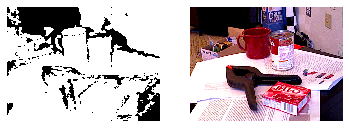

TypeError: render_obj() missing 4 required positional arguments: 'fx', 'fy', 'cx', and 'cy'

In [5]:
# we can now go and use the created depth map with the knowledge about the rotation to mimic an orginal image 
# for testing load orginal image 
# load gt transformation

from PIL import Image
base = '/media/scratch1/jonfrey/datasets/YCB_Video_Dataset/data/0003'
desig = '000010'
obj_idx_tomoto_soup = 4

img = Image.open('{0}/{1}-color.png'.format(base, desig))
depth = Image.open('{0}/{1}-depth.png'.format(base, desig))
meta = scio.loadmat('{0}/{1}-meta.mat'.format(base, desig))


fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(depth)
plt.axis("off")
fig.add_subplot(1, 2, 2)
plt.imshow(img)
plt.axis("off")
plt.show()

obj = meta['cls_indexes'].flatten().astype(np.int32)
obj_idx_in_list = int(np.argwhere(obj == obj_idx_tomoto_soup))
target_r = np.array(meta['poses'][:, :, obj_idx_in_list][:, 0:3])
target_t = np.array(
    [meta['poses'][:, :, obj_idx_in_list][:, 3:4].flatten()])[0,:]


obj = '005_tomato_soup_can'
model = '/media/scratch1/jonfrey/datasets/YCB_Video_Dataset/models'

render_img,render_depth = render_obj(obj, model, base,idx=0 , obj_dis=0.4 , r_mat= target_r )

In [6]:
# rendered object is now same as in real image. 
# next problem for offline render compute the correct scale and translation of the object in the camera coordinates.
img_r = copy.deepcopy(render_img)
img_ori = np.array(copy.deepcopy(img))
# current position of the object is 
render_t = [0,0,obj_dis]
target_t


def backproject_point(p, fx,fy,cx,cy):
    u = int(((p[0] / p[2]) * fx) + cx)
    v = int(((p[1] / p[2]) * fy) + cy)
    return u,v 

def backproject_points(p, fx,fy,cx,cy):
    """
    p.shape = (nr_points,xyz)
    """
    u = np.round(( np.true_divide( p[:,0] , p[:,2]) * fx) + cx).astype(np.int32)
    v = np.round(( np.true_divide( p[:,1] , p[:,2]) * fy) + cy).astype(np.int32)
    return np.stack([v,u]).T


#verify that backprojection of CenterOfObject works
u,v = backproject_point(render_t, fx,fy,cx,cy)
print(u,v)
d = 5
img_r[v-d:v+d,u-d:u+d,:] = [0,255,0]
fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(img_r)
plt.axis("off")
plt.show()

print(target_t)
u,v = backproject_point(target_t, fx,fy,cx,cy)
img_ori[v-d:v+d,u-d:u+d,:] = [0,255,0]
fig = plt.figure()
fig.add_subplot(1, 2, 1)
plt.imshow(img_ori )
plt.axis("off")
plt.show()

NameError: name 'render_img' is not defined

In [7]:
# next load cad_model
# sample two points with minimal distance wenn projected to the rendered image! 
# project the two points and get the scaleing transformation. 

import os
import sys
import numpy as np

os.chdir('/home/jonfrey/PLR')
sys.path.append('src')
sys.path.append('src/dense_fusion')

from loaders_v2 import Backend, ConfigLoader, GenericDataset
from visu import Visualizer
from PIL import Image
import copy
from helper import re_quat
from scipy.spatial.transform import Rotation as R

exp_cfg = ConfigLoader().from_file(
    '/home/jonfrey/PLR/src/loaders_v2/test/dataset_cfgs.yml')
env_cfg = ConfigLoader().from_file(
    '/home/jonfrey/PLR/src/loaders_v2/test/env_ws.yml')

generic = GenericDataset(
    cfg_d=exp_cfg['d_ycb'],
    cfg_env=env_cfg)

Selected points 0 1323 616
[[ 0.0570532  -0.00954669  0.774709  ]
 [ 0.05755538 -0.06993075  0.6743062 ]
 [ 0.02994209 -0.09611187  0.72859895]]


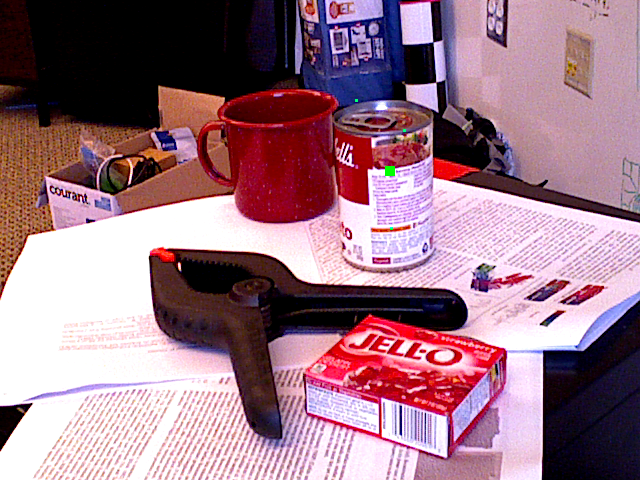

In [18]:
"""

# Checking points for real image: 
model_points = generic._backend._pcd_cad_dict[obj_idx_tomoto_soup]
target = np.dot(model_points, target_r.T)
target = np.add(target, target_t)

# select first point:
a = 0

# select secound point with maximum distance to a 
pts = target.shape[0]

a_= np.reshape(target[a,:],(1,3))
a_ =np.repeat(a_,pts, axis=0) 
dis = np.linalg.norm(target-a_ ,axis=1)
b = np.argmax(dis)

# https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line (Another vector formulation)
# select third point with maximum distance to line a->b
u = target[a,:]-target[b,:]
dis2 = []
for i in range(pts):
    nen = np.linalg.norm(np.cross(target[i,:]-target[a,:],u))
    denom = np.linalg.norm( u )
    dis_tmp = np.true_divide(nen, denom)
    dis2.append(dis_tmp)
dis2 = np.array(dis2)
c = np.argmax(dis2)

print("Selected points",a,b,c)

target_pts= target[(a,b,c),:]
print(target_pts)
visu = Visualizer(None,'/')
visu.plot_estimated_pose('Target%s' % i, 1, copy.deepcopy(img_ori), target_pts, np.zeros((1, 3)), np.eye(3),
    cam_cx=cx,
    cam_cy=cy,
    cam_fx=fx,
    cam_fy=fy,
    store=False,
    jupyter=True, w=1)

"""

In [118]:
# Checking points for real image: 
model_points = generic._backend._pcd_cad_dict[obj_idx_tomoto_soup]
target = np.dot(model_points, target_r.T)
target = np.add(target, target_t)

syn_r = target_r
syn_t = np.array([0,0,obj_dis])
model_points = generic._backend._pcd_cad_dict[obj_idx_tomoto_soup]
syn_target = np.dot(model_points, syn_r.T)
syn_target = np.add(syn_target, syn_t)

syn_target_pts= syn_target[(a,b,c),:]


# visu = Visualizer(None,'/')
# visu.plot_estimated_pose('Target%s' % i, 1, copy.deepcopy(img_r), syn_target_pts, np.zeros((1, 3)), np.eye(3),
#     cam_cx=cx,
#     cam_cy=cy,
#     cam_fx=fx,
#     cam_fy=fy,
#     store=False,
#     jupyter=True, w=1)
# print(fx,fy,cx,cy)
# print(syn_target_pts)


# render_pixles = backproject_points(syn_target_pts, fx,fy,cx,cy)
# orig_pixles = backproject_points(target[(a,b,c),:], fx,fy,cx,cy)

# print(render_pixles)
# print(orig_pixles)

# with these pixel we look for scale trans_u , trans_v

Selected points 0 1323 616


In [119]:
class bb():
    def __init__(self,p1, p2):
        "p1 = u,v  u=height v=widht starting top_left 0,0"
        if p1[0] < p2[0] and p1[1] < p2[1]:
            print("p1 = top_left")
            self.tl = p1
            self.br = p2
        elif p1[0] > p2[0] and p1[1] > p2[1]:
            print("p1 = bottom_right")
            self.br = p1
            self.tl = p2
        elif p1[0] > p2[0] and p1[1] < p2[1]:
            print("p1 = bottom_left")
            self.tl = copy.copy(p1)
            self.tl[0] =p2[0]
            self.br = p2
            self.br[0] = p1[0]
        else:
            print("p1 = top_right")
            self.br = copy.copy(p1)
            self.br[0] = p2[0]
            self.tl = p2
            self.tl[0] = p1[0]
            
    def __str__(self):
        w = self.width()
        h = self.height()
        return f'TL Cor: {self.tl}, BR Cor: {self.br}, Widht: {w}, Height: {h}'
    def width(self):

        return (self.br[1] - self.tl[1])
    def height(self):
        return (self.br[0] - self.tl[0])
    def move (self,u,v):
        self.br[0] += u
        self.tl[0] += u
        self.br[1] += v
        self.tl[1] += v
    def expand(self, r):
        r = r - 1 
        self.br[0] = int(self.br[0]+ self.height()*r)
        self.tl[0] = int(self.tl[0]- self.height()*r)
        self.br[1] = int(self.br[1]+ self.height()*r)
        self.tl[1] = int(self.tl[1]- self.height()*r)
    def add_margin(self, u,v):
        self.br[0] += u
        self.tl[0] -= u
        self.br[1] += v
        self.tl[1] -= v
    def limit_bb(self,max_height, max_width):
        if self.tl[0] < 0:
            self.tl[0] = 0
        elif self.tl[0] > max_height:
            self.tl[0] = max_height
        if self.br[0] < 0:
            self.br[0] = 0
        elif self.br[0] > max_height:
            self.br[0] = max_height
        if self.tl[1] < 0:
            self.tl[1] = 0
        elif self.tl[1] > max_width:
            self.tl[1] = max_width
        if self.br[1] < 0:
            self.br[1] = 0
        elif self.br[1] > max_width:
            self.br[1] = max_width
    def crop(self,img):
        return img[self.tl[0]:self.br[0],self.tl[1]:self.br[1],:]
    def add_noise(self, std_h, std_w):
        # std_h is the variance that is added to the top corrner position and, bottom_corner position
        self.br = np.random.normal(self.br, np.array( [std_h,std_w])  ).astype(dtype=np.int32)
        self.tl = np.random.normal(self.tl, np.array( [std_h,std_w])  ).astype(dtype=np.int32)
    def expand_to_correct_ratio(self, w,h):
        if self.width()/self.height() > w/h:
            scale_ratio = h/self.height()
            h_set = self.width()*(h/w)
            add_w = 0
            add_h = int((h_set-self.height())/2)
        else:
            scale_ratio = h/self.height()
            w_set = self.height()*(w/h)
            add_h = 0
            add_w = int((w_set-self.width())/2)

        self.add_margin(add_h,add_w)
    def plot(self, img, w=5):
        test = copy.deepcopy(img)
        w = 5
        test[self.tl[0]:self.br[0], self.tl[1]-w : self.tl[1]+w ] = [0,255,0]
        test[self.tl[0]:self.br[0], self.br[1]-w : self.br[1]+w ] = [0,255,0]
        
        test[self.tl[0]-w:self.tl[0]+w, self.tl[1] : self.br[1] ] = [0,255,0]
        test[self.br[0]-w:self.br[0]+w, self.tl[1] : self.br[1] ] = [0,255,0]

        fig = plt.figure()
        fig.add_subplot(1, 1, 1)
        plt.imshow(test)
        plt.axis("off")
        plt.show()
        
p1 = [10,130]
p2 = [20,120]
test_bb = bb(p1,p2)
print(test_bb)


p1 = top_right
TL Cor: [10, 120], BR Cor: [20, 130], Widht: 10, Height: 10


In [120]:
all_ren_pixles = backproject_points(syn_target, fx,fy,cx,cy)
all_orig_pixles = backproject_points(target, fx,fy,cx,cy)
    
    
def get_bb( pixles):
    idx_b_r =(np.argmax(pixles[:,0]),np.argmax(pixles[:,1]))
    idx_t_l =(np.argmin(pixles[:,0]),np.argmin(pixles[:,1]))
    b_r = [pixles[idx_b_r[0],0],pixles[idx_b_r[1],1]]
    t_l = [pixles[idx_t_l[0],0],pixles[idx_t_l[1],1]]
    
    return bb(b_r, t_l)
def verify(img, bb):
    test = copy.deepcopy(img)
    test[bb.tl[0]:bb.tl[0]+5,bb.tl[1]:bb.tl[1]+5] = [0,255,0]
    test[bb.br[0]:bb.br[0]+5,bb.br[1]:bb.br[1]+5] = [0,255,0]
    
    fig = plt.figure()
    fig.add_subplot(1, 1, 1)
    plt.imshow(test)
    plt.axis("off")
    plt.show()
def plt_img(img):
    fig = plt.figure()
    fig.add_subplot(1, 1, 1)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
bb_ren = get_bb(all_ren_pixles)
bb_orig = get_bb(all_orig_pixles)

w = 640
h = 480
center_ren = backproject_point(render_t, fx,fy,cx,cy)
center_orig = backproject_point(target_t, fx,fy,cx,cy)


bb_orig_cen = copy.deepcopy(bb_orig)
bb_orig_cen.move(-center_orig[0],-center_orig[1])

bb_ren_cen = copy.deepcopy(bb_ren)
bb_ren_cen.move(-center_ren[0],-center_ren[1])


p1 = bottom_right
p1 = bottom_right


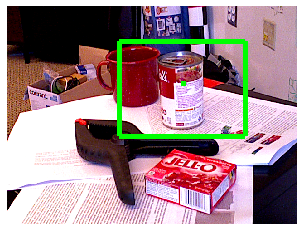

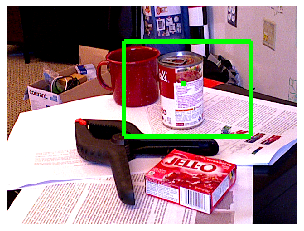

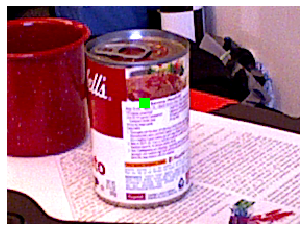

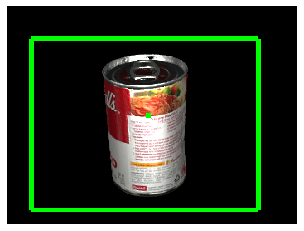

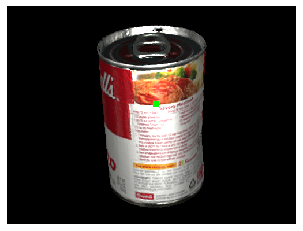

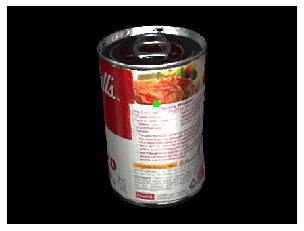

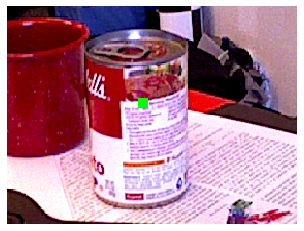

(480, 640, 3)

In [121]:

from PIL import Image
#make a deep copy so the cells are independet
bb_ren = copy.deepcopy(bb_ren_cen)
bb_orig = copy.deepcopy(bb_orig_cen)

bb_ren.expand(1.1)
bb_orig.expand(1.1)

#add margin around bb for correct ratio:
bb_ren.expand_to_correct_ratio(w,h)
bb_ren_resized = copy.deepcopy(bb_ren)
bb_ren_resized.move(+center_ren[0],+center_ren[1]) #move bb to center of object

#reshape the original
bb_orig.expand_to_correct_ratio(w,h)
bb_orig_resized = copy.deepcopy(bb_orig)
bb_orig_resized.move(+center_orig[0],+center_orig[1]) #move bb to center of object

bb_orig_resized.plot( img_ori )

bb_orig_resized.add_noise(std_h=0, std_w=30)
bb_orig_resized.expand_to_correct_ratio(w,h)


bb_orig_resized.plot( img_ori )

cropped_ori = bb_orig_resized.crop(img_ori)

plt_img(cropped_ori)

bb_ren_resized.plot(img_r)


cropped_r = bb_ren_resized.crop(img_r)

plt_img(cropped_r)


pil_r = Image.fromarray(cropped_r).resize((640,480))
plt_img(np.array(pil_r))
np.array(pil_r).shape

pil_ori = Image.fromarray(cropped_ori).resize((640,480))
plt_img(np.array(pil_ori))
np.array(pil_ori).shape

